# Using Sentiment Analysis to Improve Ad Targeting Strategies

# Introduction

Marketers today are rightfully obsessed with metrics, but amidst the sea of data, it's easy to overlook the things that aren’t easily quantifiable, like customers’ feelings and emotions. Yet, these intangible aspects can hold the key to understanding customer behavior and preferences. Enter sentiment analysis, a powerful tool that allows companies to tap into the emotional pulse of their audience, transforming abstract emotions into actionable insights.

- *Sentiment analysis is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information (Wikipedia).* 

In the digital age, social media platforms have become the new town square, a place where customers express their opinions and sentiments about brands and products. Being able to identify and categorize these opinions and determine attitudes towards a particular topic is what makes sentiment analysis so powerful. 

In this project, I will be showing how this powerful tool can be used to help companies understand their audience, improve their products, and enhance their advertising strategies. I will use a hypothetical problem statement to show how it can be used to solve real-world problems. 


# Dataset
- Load the data

In [56]:
# Load libraries
import numpy as np
import pandas as pd
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import re, nltk 
from nltk import word_tokenize
from pprint import pprint

# pd.set_option('display.max_colwidth', -1)

In [2]:
# Load data

# Validation dataset
val = pd.read_csv('twitter_validation.csv', header=None)
# Train dataset (for train-test)
train = pd.read_csv('twitter_training.csv', header=None)

In [3]:
# Set column names
train.columns = ['id', 'entity', 'sentiment', 'tweet']
val.columns = ['id','entity', 'sentiment', 'tweet']

In [4]:
train_data = train
val_data = val

Many of the tweets that are coded as "Irrelevant" are actually positive or negative tweets. I think it will hurt the model to code them as neutral, so I will remove them from the dataset. This is most likely due to an error by the dataset author when he was classifying the tweets sentiment.

In [5]:
# Remove 'Irrelevant' tweets from datasets
train_data = train_data[train_data['sentiment'] != 'Irrelevant']
val_data = val_data[val_data['sentiment'] != 'Irrelevant']

In [6]:
train_data.head()

id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               tweet  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...

## Sub-Dataframes for Analysis
Since we will be analyzing the data in different ways, it will be useful to create sub-dataframes for each of the different sentiment categories. This will make it easier to analyze the data and create visualizations. Also, since we are only analyzing the data here and not using them to build a model yet, we can combine the training and validation sets so we can have more data to work with.

In [7]:
# CS-GO data
csgo = ['CS-GO']
csgo_df_train = train_data.loc[(train_data.entity.isin(csgo))]
csgo_df_val = val_data.loc[(val_data.entity.isin(csgo))]
csgo_df = pd.concat([csgo_df_train, csgo_df_val])


# Positive and neutral tweets about CS-GO
csgo_df_pos = csgo_df.loc[(csgo_df.sentiment == 'Positive') | (csgo_df.sentiment == 'Neutral')]

# Negative tweets about CS-GO
csgo_df_neg = csgo_df.loc[(csgo_df.sentiment == 'Negative')]

In [8]:
# CS-GO direct competitors data
competitor_games = ['ApexLegends', 'Battlefield', 'CallOfDuty', 
                    'CallOfDutyBlackopsColdWar', 'Fortnite', 
                    'PlayerUnknownsBattlegrounds(PUBG)', 
                    'TomClancysGhostRecon', 'TomClancysRainbowSix']
competitors_df_train = train_data.loc[(train_data.entity.isin(competitor_games))]
competitors_df_val = val_data.loc[(val_data.entity.isin(competitor_games))]
competitors_df = pd.concat([competitors_df_train, competitors_df_val])

# Rename entities to shorter names
competitors_df['entity_shortened'] = competitors_df.entity.map({
    'ApexLegends': 'Apex',
    'Battlefield': 'Battlefield',
    'CallOfDuty': 'CoD',
    'CallOfDutyBlackopsColdWar': 'CoD BO/CW',
    'Fortnite': 'Fortnite',
    'PlayerUnknownsBattlegrounds(PUBG)': 'PUBG',
    'TomClancysGhostRecon': 'TC Ghost Recon',
    'TomClancysRainbowSix': 'TC Rainbow Six'})


# Positive and neutral tweets about competitors
competitors_df_pos = competitors_df.loc[(competitors_df.sentiment == 'Positive') | (competitors_df.sentiment == 'Neutral')]

# Create a df of only negative tweets about competitors
competitors_df_neg = competitors_df.loc[(competitors_df.sentiment == 'Negative')]

# Exploratory Data Analysis

## Understanding the Data
- Collect key metrics to help characterize the problem and help us decide which model to use.

In [9]:
# Number of samples

print('Total number of samples: ', len(train_data.index))

Total number of samples:  61692


In [10]:
# Number of classes

print('Total number of classes (sentiments): ', train_data.sentiment.nunique())
print('Sentiment classes: ', train_data.sentiment.unique())

Total number of classes (sentiments):  3
Sentiment classes:  ['Positive' 'Neutral' 'Negative']


In [11]:
# Number of samples per class

samples_per_class = np.unique(train_data.sentiment, return_counts=True)
print(f'{samples_per_class[0][0]} class: {samples_per_class[1][0]}')
print(f'{samples_per_class[0][1]} class: {samples_per_class[1][1]}')
print(f'{samples_per_class[0][2]} class: {samples_per_class[1][2]}')

Negative class: 22542
Neutral class: 18318
Positive class: 20832


In [12]:
# Median words per sample

train_data_tweets = train_data.tweet.astype(str)
# Get number of words in tweets
num_words = [len(tweet.split()) for tweet in train_data_tweets]
# Print median number of words per tweet
print('Median words per sample: ', np.median(num_words))

Median words per sample:  15.0


From these key metrics, we can calculate the number of samples/median words per sample ratio and use it to determine which model to use. If the ratio is less than 1500, we will use an n-gram model. If the ratio is more than 1500, we will use a sequence model.

S/W ratio = 61692 total samples / 15.0 median words per sample = 4112.8

Since the ratio is greater than 1500, it is recommended to use a sequence model, like RNN, CNN, or sepCNN, but I am going to use an n-gram model for this project because they are less computationally expensive and easier to implement. So, I will split the tweets into word n-grams (instead of words and converting the words into word sequence vectors) before building and evaluating SVM models, GBDT models, and a simple MLP model and selecting the model with the best performance. 

In [13]:
# Frequency distribution of words in tweets

def plot_frequency_distribution_of_words(tweets, 
                                         num_ngrams=50,
                                         ngram_range=(1,1),
                                         plot_title='Frequency distribution of words in all tweets'):
    """Plots the frequency distribution of words.

    # Arguments
        tweets: list, tweets
        num_ngrams: int, number of words to plot
            Top `num_ngrams` frequent words will be plotted
        ngram_range: ngrams to plot, default unigrams (single words)
        plot_title: string, title of the plot
    """
    # Vectorizer keyword args
    kwargs = {
            'ngram_range': ngram_range,
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are words and values are
    # indices). This also converts every text to an array the length of
    # vocabulary, where every element indicates the count of the word
    # corresponding at that index in vocabulary.
    vectorized_texts = vectorizer.fit_transform(tweets)

    # This is the list of all words in the index order from the vocabulary.
    all_words = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_words))

    # Add up the counts per word ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort words and counts by frequency and get top `num_ngrams` words.
    all_counts, all_words = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_words), reverse=True)])
    words = list(all_words)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.figure(figsize=(10,5))
    plt.bar(idx, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequencies')
    plt.title(plot_title)
    plt.xticks(idx, words, rotation=90)
    plt.show()

In [14]:
# Distribution of tweet length

def plot_tweet_length_distribution(tweets):
    '''Plots the tweet length distribution.
    
    # Arguments
        tweets: list, tweets.
    '''
    plt.hist([len(tweet.split()) for tweet in tweets], 50)
    plt.xlabel('Length of a tweet')
    plt.ylabel('Number of tweets')
    plt.title('Tweet length distribution')
    plt.show()

c:\Users\dpap\Dropbox (University of Michigan)\f22\ECE3100 DS\vscode_DS\DS_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


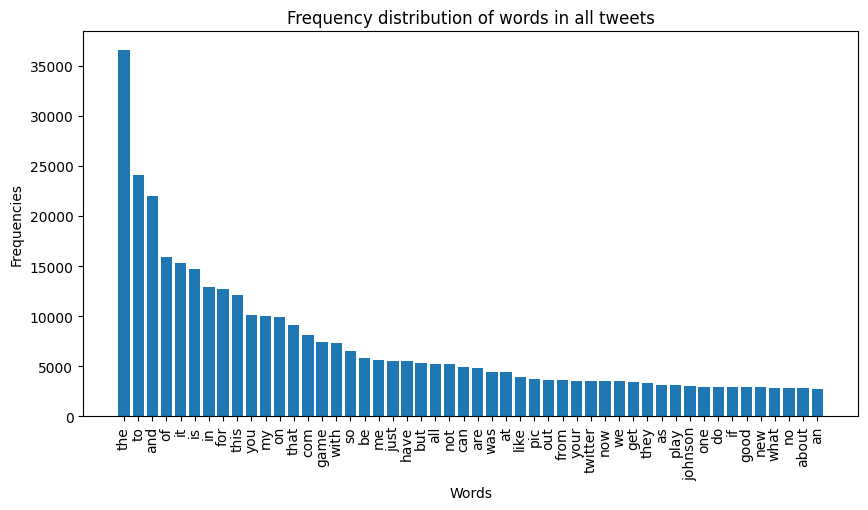

In [15]:
# Frequency distribution of words in tweets

tweets = train_data.tweet.dropna().tolist()
plot_frequency_distribution_of_words(tweets)

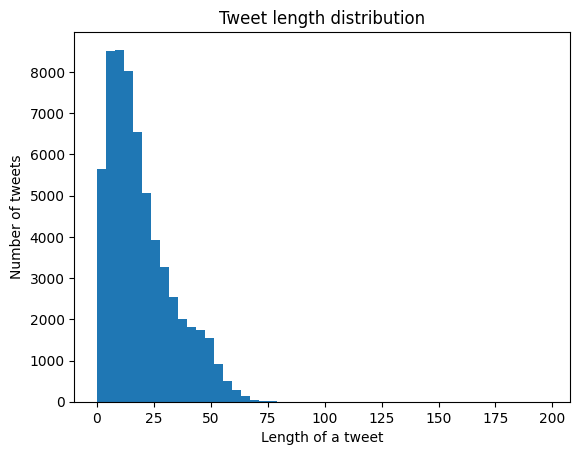

In [16]:
# Distribution of sample length

plot_tweet_length_distribution(tweets)

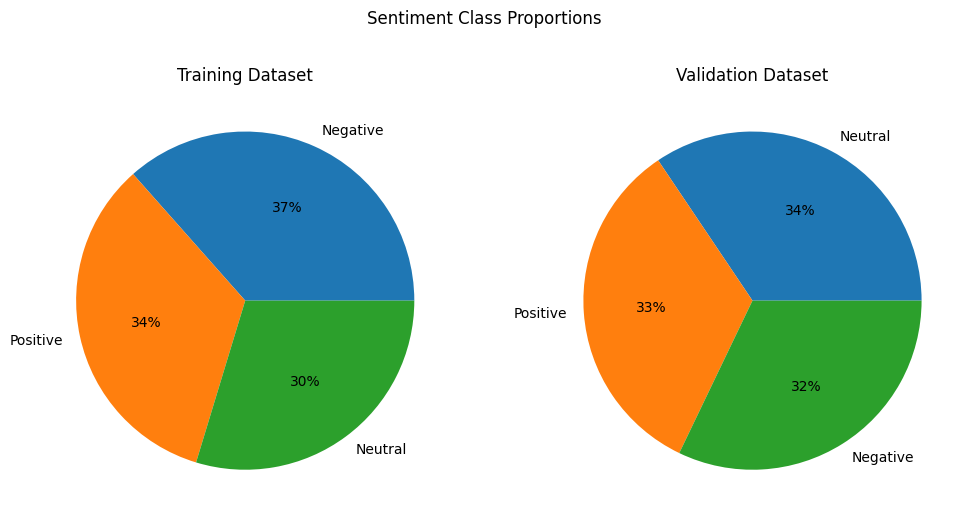

In [17]:
# Plot of sentiment class proportions

fig, ax = plt.subplots(1, 2, figsize=(12,6))
# Train set
ax[0].pie(train_data.sentiment.value_counts(),
          labels=train_data.sentiment.value_counts().index,
          autopct='%.f%%')
# Validation set
ax[1].pie(val_data.sentiment.value_counts(),
          labels=val_data.sentiment.value_counts().index,
          autopct='%.f%%')

fig.suptitle('Sentiment Class Proportions')
ax[0].set_title('Training Dataset')
ax[1].set_title('Validation Dataset')
plt.show()

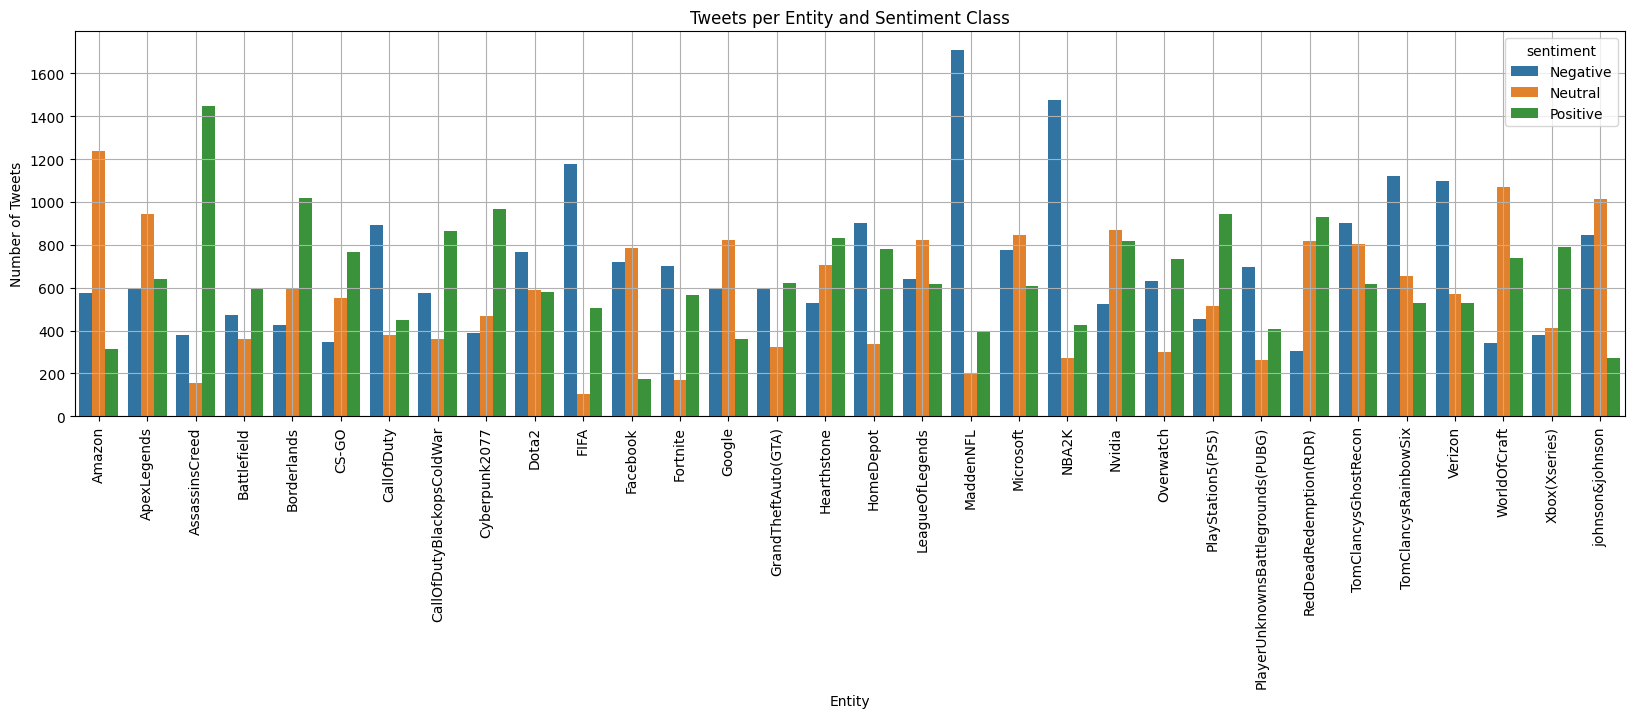

In [18]:
# Plot of tweets per entity and sentiment class

tweets_by_entity = train_data.groupby(by=['entity', 'sentiment']).count().reset_index()
plt.figure(figsize=(20,5))
sns.barplot(data=tweets_by_entity, x='entity', y='id', hue='sentiment')
plt.xticks(rotation=90)
plt.xlabel('Entity')
plt.ylabel('Number of Tweets')
plt.title('Tweets per Entity and Sentiment Class')
plt.grid()
plt.show()

## CS-GO Analysis
- Analyze tweets about CS-GO to understand the audience

### Word Clouds
To see what people were saying about these games, I initially wanted to do topic modeling. After my first attempt, I found that the topics were not very useful. After further research, I found that topic modeling (specifically, LDA) does not perform well on short texts. So, to get a general idea about what users are saying about competitors, I decided to use word clouds instead. Information from the word clouds and my domain knowledge of the games will be used to create ads that will appeal to the target audience.

In [19]:
def make_wordcloud(tweet_col,
                   stop_words,
                   title):
    '''Function to generate a word cloud.
    
    Arguments
        tweet_col: df column to make word cloud for ('tweet' column)
        stopwords: a set of stopwords
        title: string, plot title
    
    Returns
        Prints a word cloud
    '''
    tweets = tweet_col.astype(str)
    tweets_text = ' '.join(tweet for tweet in tweets)
    
    wordcloud = WordCloud(stopwords=stop_words).generate(tweets_text)
    fig, ax = plt.subplots(figsize=(15,15))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, weight='bold')
    plt.show()

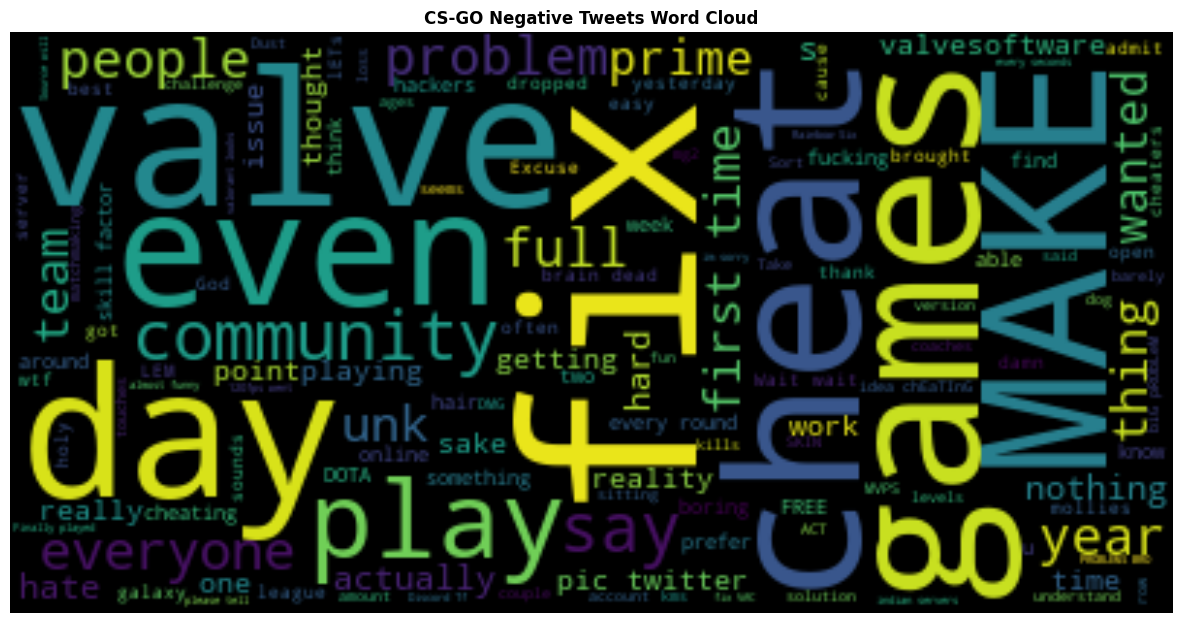

In [20]:
# CS-GO Negative Word Cloud

# Set of stopwords
stopwords = set(STOPWORDS)

# Words to exclude
stopwords.update(['CSGO', 'cs', 'game', 'go', 'fuck', 'shit', 'see',
                  'RhandlerR'])

make_wordcloud(csgo_df_neg['tweet'], stopwords, title='CS-GO Negative Tweets Word Cloud')

The word cloud generated from negative tweets about CS-GO confirms a significant problem with the game: cheaters and hackers. This has been a frequent complaint among players for years, and this issue, if left unaddressed, can severly impact the game's reputation.

To tackle this, developers should consider implementing a robust and efficient anti-cheat system. The game Valorant was able to do something like this and have been successful in keeping cheaters at bay. Furthermore, transparent communication about the steps being taken to combat the cheating can also restore the players' trust in the game. This could include regular updates about the improvements made on the system, statistics about the number of cheaters caught and banned, and future plans to enhance security. 

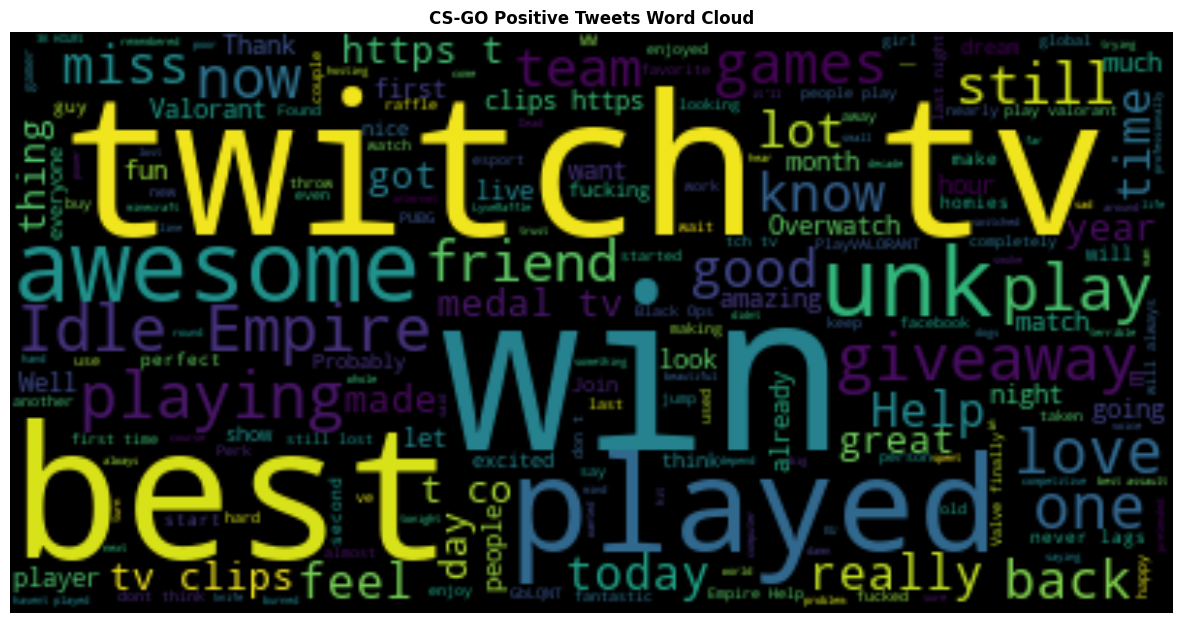

In [21]:
# CS-GO Positive Word Cloud

# Words to exclude
stopwords.update(['CSGO', 'cs', 'game', 'go', 'fuck', 'shit', 'see',
                  'pic', 'wn', 'nr', 'twitter'])

make_wordcloud(csgo_df_pos['tweet'], stopwords, title='CS-GO Positive Tweets Word Cloud')

The positive word cloud for CS-GO reveals a vibrant community centered around skin giveaways and Twitch streaming. This suggests a high level of engagement among players, who not only play the game but also participate in related activities such as watching live streams and participating in giveaways.

To leverage this information, CS-GO could consider partnering with popular Twitch streamers for promotional events, such as exclusive skin giveaways. This could increase the game's visibility on the platform and attract new players. Additionally, CS-GO could also host official tournaments or events and stream them on Twitch, further engaging the community.

Moreover, recognizing the popularity of skin giveaways, CS-GO could consider introducing more in-game items and organizing regular official giveaways. This could enhance player engagement and retention, as players would be incentivized to continue playing the game for a chance to win these items.

## Competitor Analysis
- Analyze tweets about competitors to understand the audience and identify opportunities

In [22]:
# Get the number of people who tweeted negatively about each competitor

neg_tweeters_per_entity = competitors_df_neg.groupby(
    'entity_shortened')['id'].nunique().reset_index(
        name='unique_ids').sort_values(by='unique_ids')

neg_tweeters_per_entity

entity_shortened  unique_ids
1      Battlefield          79
3        CoD BO/CW          96
0             Apex         100
5             PUBG         116
4         Fortnite         117
2              CoD         149
6   TC Ghost Recon         150
7   TC Rainbow Six         187

In [23]:
# See number of negative tweets and total tweets for each competitor
# and the proportion of tweets that are negative

# Get number of tweets for each competitor
tweet_count_by_entity = competitors_df.groupby(
    by=['entity_shortened']).size().reset_index(
        name='total_tweets')

# Get number of negative tweets for each competitor
neg_tweet_count_by_entity = competitors_df_neg.groupby(
    by=['entity_shortened']).size().reset_index(
        name='negative_tweets')

tweet_counts = pd.merge(tweet_count_by_entity, neg_tweet_count_by_entity, 
                        on='entity_shortened').sort_values(by='total_tweets')

# Calculate percentage of negative tweets for each entity
tweet_counts['negative_pct'] = (tweet_counts['negative_tweets'] / 
                                tweet_counts['total_tweets'] * 100)

# Sort by negative percentage
tweet_counts = tweet_counts.sort_values(by='negative_pct')

tweet_counts

entity_shortened  total_tweets  negative_tweets  negative_pct
0             Apex          2217              606     27.334235
3        CoD BO/CW          1819              579     31.830676
1      Battlefield          1442              481     33.356449
6   TC Ghost Recon          2344              912     38.907850
7   TC Rainbow Six          2338             1131     48.374679
4         Fortnite          1453              715     49.208534
5             PUBG          1391              706     50.754853
2              CoD          1742              902     51.779564

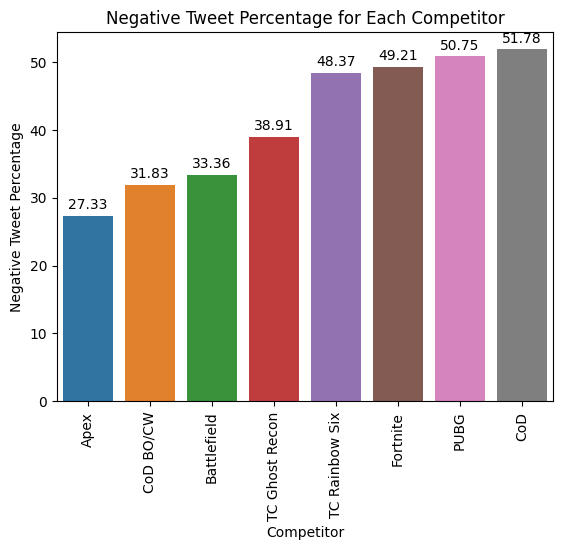

In [24]:
# Barplot of competitors negative tweet percentage
barplot = sns.barplot(data=tweet_counts,
                      x='entity_shortened', 
                      y='negative_pct')

# Add percentage to the top of the bars
for bar in barplot.patches:
    barplot.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
    
plt.title('Negative Tweet Percentage for Each Competitor')
plt.xlabel('Competitor')
plt.ylabel('Negative Tweet Percentage')
plt.xticks(rotation=90)
plt.show()

Given the fact that the proportion of negative tweets are so high for Call of Duty, PUBG, Fortnite, and Tom Clancy's Rainbow Six, these users would be a good starting point for CS-GO ads. To see what kind of ads would be most effective, we will analyze the tweets to see what people are saying about these games.

In [25]:
# Sub-dataframes for specific competitors
cod_neg = competitors_df_neg[competitors_df_neg.entity_shortened == 'CoD']
pubg_neg = competitors_df_neg[competitors_df_neg.entity_shortened == 'PUBG']
fortnite_neg = competitors_df_neg[competitors_df_neg.entity_shortened == 'Fortnite']
r6_neg = competitors_df_neg[competitors_df_neg.entity_shortened == 'TC Rainbow Six']

### Call of Duty

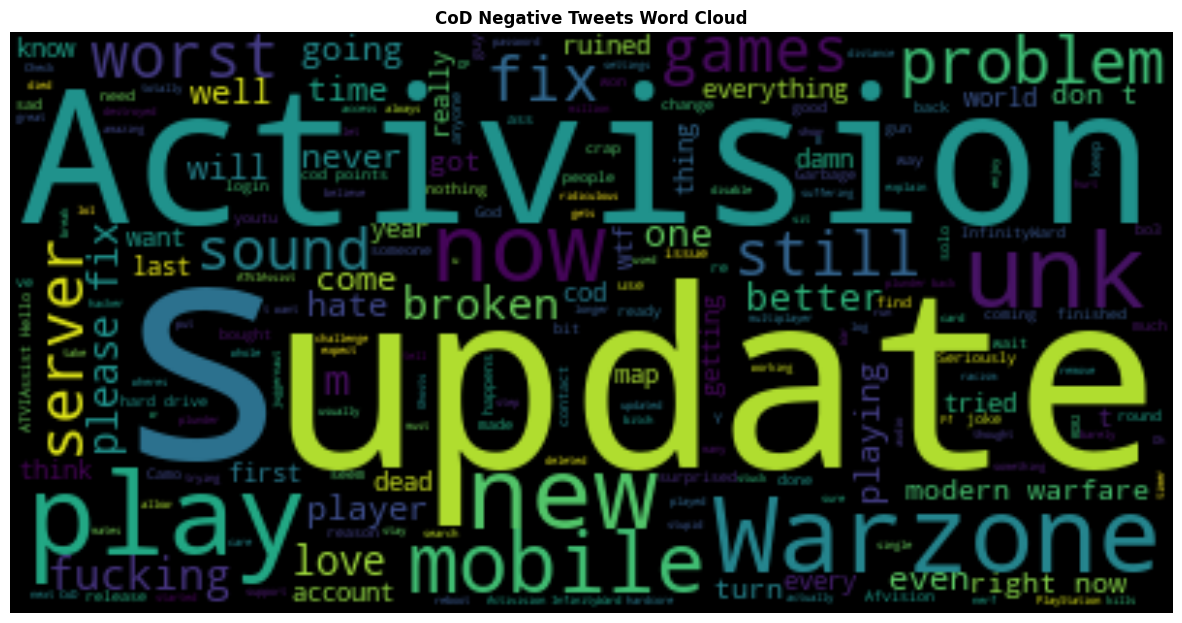

In [26]:
# CoD Negative Word Cloud

# Words to exclude
stopwords.update(['CallofDuty', 'call', 'duty', 'CfDuty',
                  'pic', 'twitter', 'game'])

make_wordcloud(cod_neg['tweet'], stopwords, 
               title='CoD Negative Tweets Word Cloud')

Analyzing the negative tweets about Call of Duty, we find that a majority of the tweets are talking about Warzone, which is their free-to-play battle royale game. One of the biggest complaints about the game has to do with their updates. These updates are usually very frequent and large in size (sometimes even larger than the game itself). Another interesting finding is that many of the tweets are talking about the game being "dead". Given these findings, it would be smart to target these users with ads about CS-GO's free-to-play battle royale game, Danger Zone, and their smaller updates. It would also be smart to touch on CS-GO being the most played game on Steam.

### PUBG

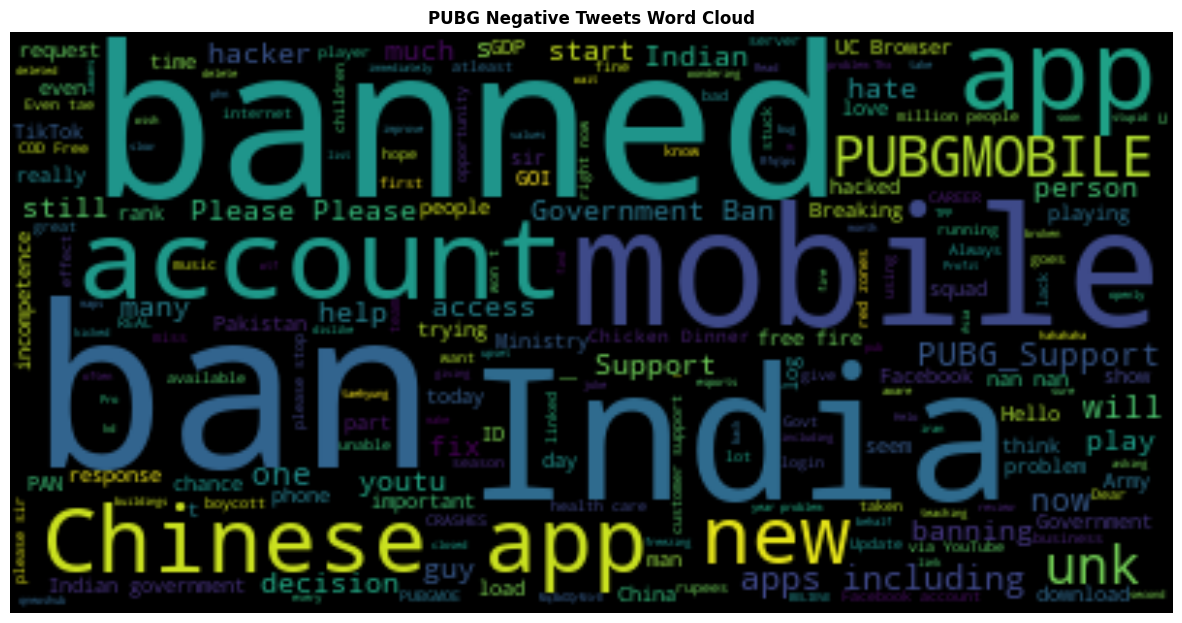

In [27]:
# PUBG negative tweets word cloud

# Words to exclude
stopwords.update(['PUBG'])

make_wordcloud(pubg_neg['tweet'], stopwords, 
               title='PUBG Negative Tweets Word Cloud')

Analyzing the word cloud of negative tweets about PUBG, a striking pattern emerges. The words "banned", "India", and "China" are very prominent, indicating a significant volume of conversation around the game's prohibition in these major markets. This presents a unique opportunity for CS-GO. 

Given the vacuum created by PUBG's absence, there is a large pool of disenchanted gamers in India and China who are looking for an alternative. CS-GO can leverage this situation by emphasizing the aspects that made these users enjoy PUBG, such as the competitive multiplayer experience. Furthermore, CS-GO can also reassure these users about its availability and commitment to these markets.

### Fortnite

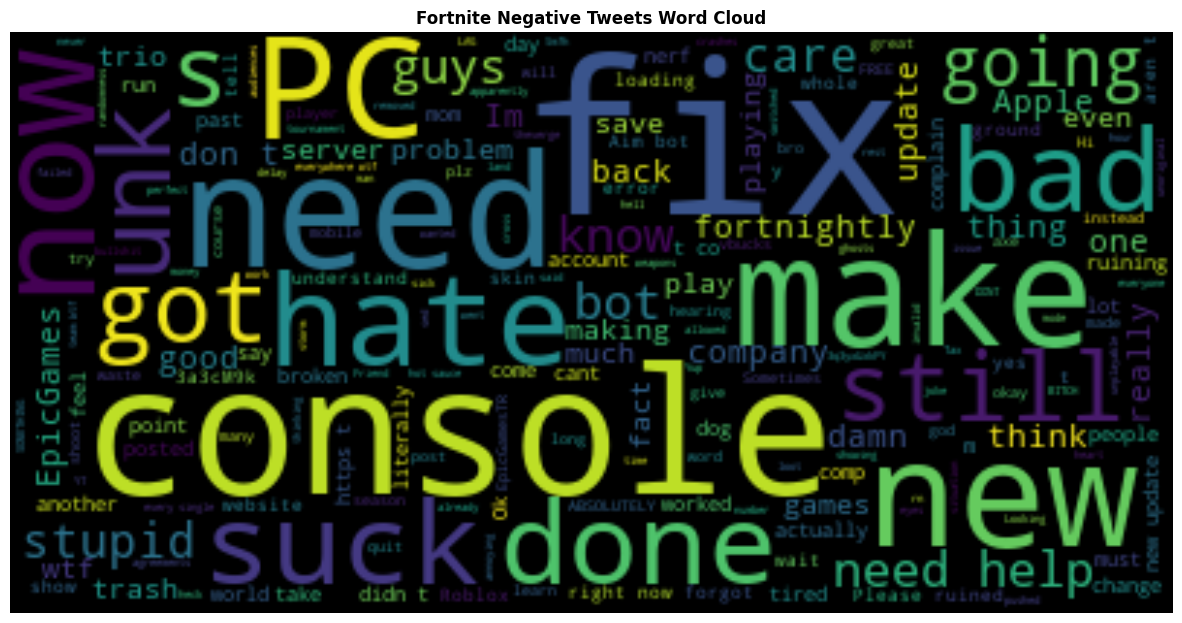

In [28]:
# Fortnite negative tweets word cloud

# Words to exclude
stopwords.update(['Fortnite', 'FortniteGame', 'benniteGame', 
                  'Epic', 'fuck', 'fucking', 'tt', '3a3cN9k'])

make_wordcloud(fortnite_neg['tweet'], stopwords, 
               title='Fortnite Negative Tweets Word Cloud')

### Tom Clancy's Rainbow Six

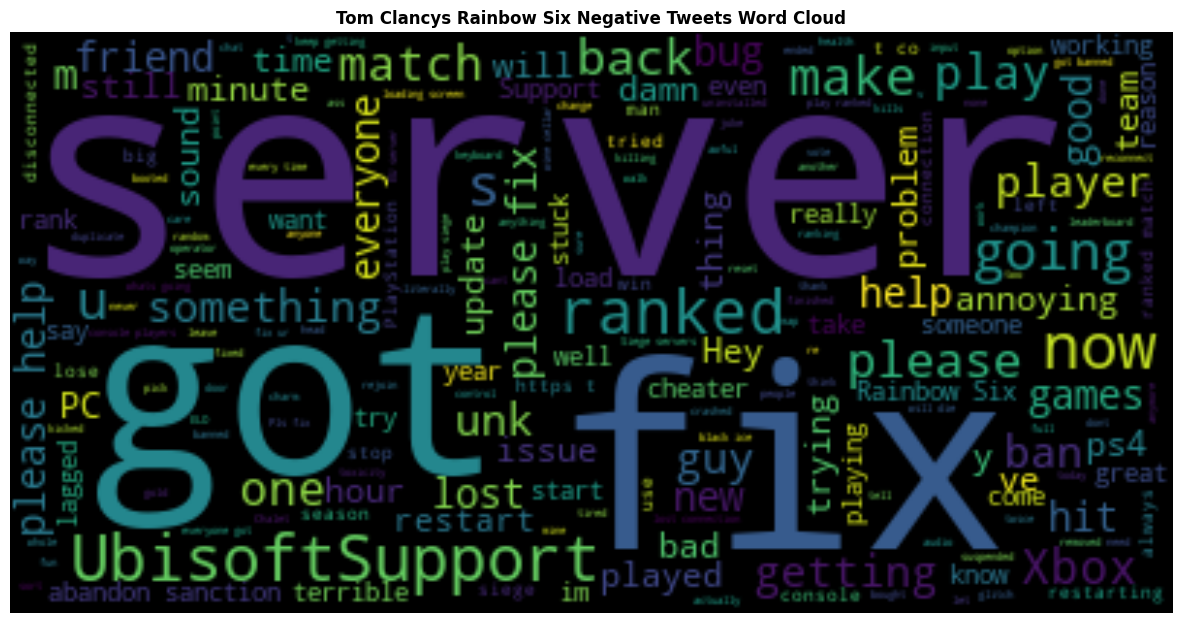

In [29]:
# Tom Clancys Rainbow Six negative tweets word cloud

# Words to exclude
stopwords.update(['Rainbow6Game', 'Ubisoft'])

make_wordcloud(r6_neg['tweet'], stopwords, 
               title='Tom Clancys Rainbow Six Negative Tweets Word Cloud')

The negative tweets about Tom Clancy's Rainbow Six revealed that many players are unhappy with the amount of bugs in the game, with many players calling for the developers to fix them. This indicates the importance of a responsive development team that listens to their players. CS-GO can leverage this by emphasizing the fact that they have a dedicated team that is constantly working to improve the game and showing the game's reliability and stability.

# Data Preprocessing
In this section, we will clean the data and prepare it for modeling. We will remove punctuation, numbers, and special characters, and convert all letters to lowercase. We will also perform lemmatization and do vectorization using TF-IDF Vectorizer. To summarize what will be done in this section, we will:
- Split the samples into word n-grams and convert the n-grams into vectors.
- Score the importance of the vectors and select the top 20,000 features using the scores.
- Perform label encoding.
- Split the data to create a holdout set for final evaluation.

In [30]:
def clean_tweets(df):
   '''Function to convert tweet to lowercase and remove special
        characters. The result is put in a new column in the dataframe
    
    # Arguments
        df: dataframe to apply transformations to
        
    # Returns
        df: returns the modified dataframe with a new column 
            called 'tweets_cleaned'
    '''
   # Convert tweets to lowercase and remove special characters
   df['tweets_lower'] = df.tweet.str.lower()
   df['tweets_lower'] = df.tweets_lower.apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', ' ', str(x)))
   
   return df

In [31]:
# Function that will tokenize and lemmatize tweets in TfidfVectorizer
lemmatizer = nltk.WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    '''Function to tokenize and lemmatize tweets.'''
    return [lemmatizer.lemmatize(word) for word in word_tokenize(text)]

In [51]:
# Vectorization parameters

# Use uni + bigrams
NGRAM_RANGE = (1,2)

# Limit the number of features to the top 20,000
TOP_K = 20000

# Tokenize the tweets into words (instead of characters)
TOKEN_MODE = 'word'

# If a word occurs in <2 tweets, it will be discarded as a feature
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_data, val_data, text_column, label_column, tokenizer):
    '''Vectorizes tweets as n-gram vectors.

    # Arguments
        train_data: dataframe, training data
        val_data: dataframe, validation data
        text_column: string, name of the column containing text
        label_column: string, name of the column containing labels
        tokenizer: callable, function to use for tokenization and 
                    lemmatization

    # Returns
        x_train, x_val: vectorized training and validation texts
    '''
    # Keyword arguments for tf-idf vectorizer
    kwargs = {
        'ngram_range': NGRAM_RANGE,
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,
        'min_df': MIN_DOCUMENT_FREQUENCY,
        'tokenizer': tokenizer,
        'stop_words': 'english'
    }
    vectorizer = TfidfVectorizer(**kwargs)
    
    # Learn vocabulary from training texts and vectorize training texts
    x_train = vectorizer.fit_transform(train_data[text_column])

    # Vectorize validation texts
    x_val = vectorizer.transform(val_data[text_column])
    
    # Select top 20,000 of the vectorized features based on their
    # ANOVA F-value
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_data[label_column])
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')

    return x_train, x_val, vectorizer, selector

In [33]:
# Apply cleaning to training data
train_data = clean_tweets(train_data)

# Apply cleaning to validation data
val_data = clean_tweets(val_data)

C:\Users\dpap\AppData\Local\Temp\ipykernel_24532\1234778328.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweets_lower'] = df.tweet.str.lower()
C:\Users\dpap\AppData\Local\Temp\ipykernel_24532\1234778328.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweets_lower'] = df.tweets_lower.apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', ' ', str(x)))
C:\Users\dpap\AppData\Local\Temp\ipykernel_24532\1234778328.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [34]:
# Confirm cleaning changes
train_data.head()

id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                               tweet  \
0  im getting on borderlands and i will murder yo...   
1  I am coming to the borders and I will kill you...   
2  im getting on borderlands and i will kill you ...   
3  im coming on borderlands and i will murder you...   
4  im getting on borderlands 2 and i will murder ...   

                                        tweets_lower  
0  im getting on borderlands and i will murder yo...  
1  i am coming to the borders and i will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...

In [52]:
# Apply vectorizer to training and validation data
X_train, X_val, vectorizer, selector = ngram_vectorize(train_data, val_data, 
                                                       'tweets_lower', 'sentiment', 
                                                       tokenize_and_lemmatize)

c:\Users\dpap\Dropbox (University of Michigan)\f22\ECE3100 DS\vscode_DS\DS_env\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [36]:
# See a sample of the document-term matrix (sparse matrix format)
print(X_train[0:1])

  (0, 3234)	0.22942558
  (0, 7797)	0.24489476
  (0, 9236)	0.2769665
  (0, 9239)	0.42599523


In [37]:
# Encode the labels in the training and validation sets
le = LabelEncoder()
train_data['sentiment_encoded'] = le.fit_transform(train_data['sentiment'])
val_data['sentiment_encoded'] = le.transform(val_data['sentiment'])

C:\Users\dpap\AppData\Local\Temp\ipykernel_24532\949954351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['sentiment_encoded'] = le.fit_transform(train_data['sentiment'])
C:\Users\dpap\AppData\Local\Temp\ipykernel_24532\949954351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['sentiment_encoded'] = le.transform(val_data['sentiment'])


In [38]:
# Extract labels from training and validation sets
y_train = train_data['sentiment_encoded']
y_val = val_data['sentiment_encoded']

In [39]:
# Make a training and test set to evaluate different models
X_train_small, X_test, y_train_small, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42
)

In [40]:
# Convert the tweets to dense numpy arrays so they can be input into MLP model

# For testing the model
X_train_small_mlp = X_train_small.toarray()
X_test_mlp = X_test.toarray()

# For final evaluation (holdout set)
X_train_mlp = X_train.toarray() 
X_val_mlp = X_val.toarray()

# Modeling Building and Evaluation
In this section, we will build and evaluate SVM models, GBDT models, and a simple MLP model and select the model with the best performance. 

In [41]:
# Function to make predictions and print classification report
def train_model(model_object, training_feat=X_train_small, 
                training_label=y_train_small, testing_feat=X_test, 
                testing_label=y_test):
    '''Function to make predictions and evaluate model.
    
    Argument
        model_object: an instance of the model you want to evaluate
        training_feat: vectorized training tweets, default=X_train_small
        training_label: encoded training label, default=y_train_small
        testing_feat: vectorized testing tweets, default=X_test
        testing_label: encoded testing label, default=y_test
    
    Returns
        Prints the accuracy, classification report, and confusion matrix
    '''
    fit_model = model_object.fit(training_feat, training_label)
    y_pred = fit_model.predict(testing_feat)
    print(f'MODEL USED: {model_object}\n')
    print('Accuracy: ', accuracy_score(testing_label, y_pred))
    print('Classification report: \n', classification_report(testing_label, y_pred))
    print('CM: \n', confusion_matrix(testing_label, y_pred))
    print()

In [57]:
# Number of units and activation function for last layer
# Output units = number of classes = 3
OP_UNITS = 3 # We have 3 sentiment classes, which means use 'softmax'
# Since we have 3 classes, we must use softmax activation function
# on the last layer of the network (for multi-class classification)
OP_ACTIVATION = 'softmax'

# Function to instantiate the MLP model
def mlp_model(layers, units, dropout_rate, input_shape):
    '''Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model
        units: int, output dimension of the layers
        dropout_rate: float, percentage of input to drop at Dropout layers
        input_shape: tuple, shape of input to the model

    # Returns
        An MLP model instance
    '''
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(units=OP_UNITS, activation=OP_ACTIVATION))
    return model

In [58]:
# Function to train the MLP model
def train_mlp_model(model_instance,
                    X_train_array=X_train_small_mlp,
                    train_label=y_train_small,
                    X_test_array=X_test_mlp,
                    test_label=y_test, 
                    epochs=1000,
                    batch_size=128,
                    learning_rate=0.001):
    '''Trains MLP model on the given dataset.

    # Arguments
        model_instance: an MLP model instance
        epochs: int, number of epochs
        batch_size: int, number of samples per batch
    '''
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model_instance.compile(optimizer=optimizer,
                           loss='sparse_categorical_crossentropy',
                           metrics=['acc'])
    
    # Create a callback for early stopping on val loss. If loss doesn't 
    # decrease in 2 consecutive tries, stop training
    callbacks = [EarlyStopping(monitor='val_loss',
                               patience=2)]
    
    # Train and validate model
    history = model_instance.fit(
        X_train_array, 
        train_label,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(X_test_array, test_label),
        #verbose=2, # Logs once per epoch
        batch_size=batch_size)
    
    # Print results
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
        acc=history['val_acc'][-1], loss=history['val_loss'][-1]))
    history_df = pd.DataFrame(history)
    history_df.loc[:,['loss','val_loss']].plot()
    
    # Save model
    model_instance.save('twitter_mlp_model.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

In [44]:
# Model objects to evaluate

# LinearSVC with no parameters
svm_clf = LinearSVC()

# LinearSVC with hinge loss function (hinge is what SVC uses)
svm_clf_hinge = LinearSVC(loss='hinge')

# GBDT model
gbc = GradientBoostingClassifier(n_estimators=150, max_depth=7, learning_rate=0.01)

In [45]:
# Fit and evaluate LSVC model with no parameters
train_model(svm_clf)

MODEL USED: LinearSVC()

Accuracy:  0.8657913931436907
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      4509
           1       0.92      0.86      0.89      3650
           2       0.87      0.84      0.86      4180

    accuracy                           0.87     12339
   macro avg       0.87      0.86      0.87     12339
weighted avg       0.87      0.87      0.87     12339

CM: 
 [[4038  139  332]
 [ 329 3136  185]
 [ 539  132 3509]]



In [46]:
# LinearSVC with hinge loss function
train_model(svm_clf_hinge)

MODEL USED: LinearSVC(loss='hinge')

Accuracy:  0.8329686360320934
Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      4509
           1       0.92      0.78      0.85      3650
           2       0.82      0.82      0.82      4180

    accuracy                           0.83     12339
   macro avg       0.84      0.83      0.83     12339
weighted avg       0.84      0.83      0.83     12339

CM: 
 [[3987  107  415]
 [ 463 2863  324]
 [ 625  127 3428]]



c:\Users\dpap\Dropbox (University of Michigan)\f22\ECE3100 DS\vscode_DS\DS_env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [47]:
# GBDT model
train_model(gbc)

MODEL USED: GradientBoostingClassifier(learning_rate=0.01, max_depth=7, n_estimators=150)

Accuracy:  0.5952670394683524
Classification report: 
               precision    recall  f1-score   support

           0       0.51      0.90      0.65      4509
           1       0.77      0.37      0.50      3650
           2       0.73      0.47      0.57      4180

    accuracy                           0.60     12339
   macro avg       0.67      0.58      0.57     12339
weighted avg       0.66      0.60      0.58     12339

CM: 
 [[4051  178  280]
 [1848 1342  460]
 [2001  227 1952]]



Epoch 1/1000
386/386 [==============================] - 8s 20ms/step - loss: 0.8116 - acc: 0.6867 - val_loss: 0.5604 - val_acc: 0.7961
Epoch 2/1000
386/386 [==============================] - 7s 19ms/step - loss: 0.4877 - acc: 0.8151 - val_loss: 0.4043 - val_acc: 0.8523
Epoch 3/1000
386/386 [==============================] - 8s 20ms/step - loss: 0.3913 - acc: 0.8440 - val_loss: 0.3447 - val_acc: 0.8681
Epoch 4/1000
386/386 [==============================] - 8s 20ms/step - loss: 0.3517 - acc: 0.8558 - val_loss: 0.3158 - val_acc: 0.8732
Epoch 5/1000
386/386 [==============================] - 8s 21ms/step - loss: 0.3286 - acc: 0.8614 - val_loss: 0.3000 - val_acc: 0.8786
Epoch 6/1000
386/386 [==============================] - 7s 19ms/step - loss: 0.3109 - acc: 0.8669 - val_loss: 0.2900 - val_acc: 0.8798
Epoch 7/1000
386/386 [==============================] - 7s 19ms/step - loss: 0.3002 - acc: 0.8689 - val_loss: 0.2807 - val_acc: 0.8850
Epoch 8/1000
386/386 [==============================] -

(0.9062322974205017, 0.23831158876419067)

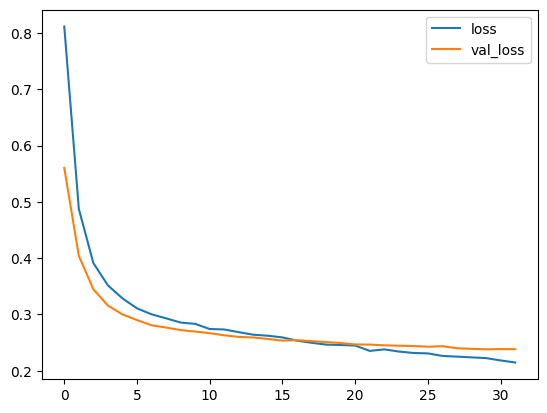

In [59]:
# MLP model

# Model parameters
LAYERS = 2  # Can try 1, 2, or 3
UNITS = 64  # 32 or 64 are best
DROPOUT_RATE = 0.2  # Range: 0.2-0.5

EPOCHS = 1000  # Because we have early stopping
BATCH_SIZE = 128
LEARNING_RATE = 0.001  # 0.0001 - 0.01

# Make model instance
model_mlp = mlp_model(LAYERS, UNITS, DROPOUT_RATE, X_train.shape[1:])

# Train MLP model
train_mlp_model(model_instance=model_mlp,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                learning_rate=LEARNING_RATE)

The MLP model predicted the sentiment of the tweets about 91.14% of the time on the validation set (test set). This is the best model by a pretty good margin.

## Hyperparameter Tuning

In [49]:
# # MLP model hyperparameter tuning

# # Model parameters
# LAYERS = 2  # Can try 1, 2, or 3
# UNITS = 64  # 32 or 64 are best
# DROPOUT_RATE = 0.2  # Range: 0.2-0.5

# EPOCHS = 1000  # Because we have early stopping
# BATCH_SIZE = 128
# LEARNING_RATE = 0.01  # 0.0001 - 0.01

# # Make model instance
# model_mlp = mlp_model(LAYERS, UNITS, DROPOUT_RATE, X_train.shape[1:])

# Model Validation
Here we will evaluate the best performing model on the holdout set to see how it performs on unseen data.

In [60]:
# Evaluate MLP model on unseen data (holdout set) to verify performance

# Load trained model
model = load_model('twitter_mlp_model.h5')

# Evaluate model 
loss, accuracy = model.evaluate(X_val_mlp, y_val)

print('Test accuracy:', accuracy)
print('Test loss:', loss)


26/26 [==============================] - 0s 2ms/step - loss: 0.1949 - acc: 0.9469
Test accuracy: 0.9468598961830139
Test loss: 0.1949293464422226


To apply the model to future tweets, I will create a function that will take in a tweet and return the predicted sentiment and the class probabilities. This function can then be used to predict the sentiment of tweets or other text data in different datasets by applying the function to the text column of the dataset. 

I will also create a function that will take in a tweet or sentence and return the predicted sentiment and the probability of each sentiment class so I can evaluate how the model works on different sounding sentences. This will be used to get some insight on how the model works and to see if there are any areas for improvement.

In [99]:
def predict_sentiment(input_sentence, model):
    '''Function to predict sentiment of a sentence using trained model.

    # Arguments
        input_sentence: string, input sentence for which to predict sentiment

    # Returns
        predicted_sentiment: string, predicted sentiment 
        prediction[0]: sentiment class probabilities, outputs Negative, 
            Neutral, Positive, in that order
    '''
    # Create a dataframe from the input sentence
    input_df = pd.DataFrame([input_sentence], columns=['tweet'])
    
    # Clean the sentence
    input_df = clean_tweets(input_df)
    
    # Vectorize and select top features
    input_vector = vectorizer.transform(input_df['tweets_lower'])
    input_vector = selector.transform(input_vector).astype('float32')
    
    # Make prediction
    prediction = model.predict(input_vector)
    
    # Convert prediction to label
    sentiment_dict = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_dict[np.argmax(prediction)]
    
    # Return the sentiment prediction and the probabilities for each class
    # Order of probabilities output: 'Negative', 'Neutral', 'Positive'
    return predicted_sentiment, prediction[0] #TODO: do i need to remove prediction[0]?
                                                # So i can use this function on 
                                                # a new dataset using .apply and lambda? 
                                                # Will the predictions[0] mess that up?

In [97]:
def sentence_testing(sentence, intended_sentiment):
    '''Function to print the predicted sentiment and probabilities of a 
        sentence to test the model on different sentences.
    
    Arguments
        sentence: string, sentence to predict sentiment for
        intended_sentiment: string, how you would label the sentiment of the 
            sentence ('Negative', 'Neutral', or 'Positive')
    
    Returns
        Prints the predicted sentiment of the sentence and the probabilities
        of each of the sentiment classes.
    '''
    sentiment, probabilities = predict_sentiment(sentence, model)
    print(f'\nPrediction for a {intended_sentiment}-sounding sentence:\n')
    print(f'\tSentence: {sentence}')
    print(f'\tPredicted sentiment: {sentiment}')
    print(f'\tNegative probability: {probabilities[0]}')
    print(f'\tNeutral probability: {probabilities[1]}')
    print(f'\tPositive probability: {probabilities[2]}\n')

In [98]:
negative_sentence = 'I Hate CSGO so much!!'
neutral_sentence = 'CSGO stock is at a certain level'
positive_sentence = 'The best game ever is CSGO!'
sentence_testing(negative_sentence, 'NEGATIVE')
sentence_testing(neutral_sentence, 'NEUTRAL')
sentence_testing(positive_sentence, 'POSITIVE')

1/1 [==============================] - 0s 13ms/step



Prediction for a NEGATIVE-sounding sentence:

	Sentence: I Hate CSGO so much!!
	Predicted sentiment: Negative
	Negative probability: 0.926272988319397
	Neutral probability: 0.025521552190184593
	Positive probability: 0.04820548743009567

1/1 [==============================] - 0s 11ms/step

Prediction for a NEUTRAL-sounding sentence:

	Sentence: CSGO stock is at a certain level
	Predicted sentiment: Negative
	Negative probability: 0.5177530646324158
	Neutral probability: 0.0009910339722409844
	Positive probability: 0.4812559187412262

1/1 [==============================] - 0s 11ms/step

Prediction for a POSITIVE-sounding sentence:

	Sentence: The best game ever is CSGO!
	Predicted sentiment: Positive
	Negative probability: 0.10204833745956421
	Neutral probability: 0.40071606636047363
	Positive probability: 0.4972355365753174



When evaluating different sentences, the model is predicting that neutral-sounding sentences are negative. If the model is predicting them as negative, then it might not be a major issue because we are targeting negative tweets, therefore, we will just have a larger ad target list. However, this is still not ideal. This could be happening because of how the data I used to train the model was labeled. Upon further inspection of this, I did find that many of the tweets labeled 'Neutral' were actually negative. This is most likely what is causing the model to predict neutral-sounding sentences as negative. To fix this, I would need to re-label the data.

Another way to improve the model's performance on neutral sentiment, we could collect more data so the model can learn to recognize neutral sentiment better. We could also try a different model, like a sequence model, which would be good for this task because they can capture the sequential nature of text.

In [ ]:
# # How to apply the function to a new dataset
# # For example, say you read in a CSV file and it has a column named 'review'.

# # Read in the new dataset
# df = pd.read_csv('new_dataset.csv')

# # Add a column to the df that has the predictions
# df['predictions'] = df['review'].apply(lambda x: predict_sentiment(x))

# # See the predictions
# df.head()

# Application to Ad Targeting/Business Recommendations
Based on the analysis of the word clouds and the performance of the sentiment analysis model, the following business recommendations can be made:

- **Addressing Negative Sentiments:** The negative sentiment word cloud for CS:GO reveals a significant concern about cheaters and hackers. It's crucial to address this issue to improve user experience and retain players. This could involve enhancing the game's security measures, implementing stricter penalties for cheating, and improving the game's cheat detection capabilities.

- **Leveraging Twitch and Skin Giveaways:** The positive sentiment word cloud for CS:GO shows a strong community presence on Twitch and a high interest in skin giveaways. CS:GO can leverage this by partnering with popular Twitch streamers for promotional events and organizing regular official skin giveaways to enhance player engagement.

- **Targeting Disgruntled Competitor Players:** The negative sentiment word clouds for competitor games that have a high proportion of negative tweets written about them can be used to create user profiles for targeting. These profiles can be used to create ad campaigns that highlight CS:GO's features that are most likely to appeal to these users. Some examples of these ad campaigns are:
  
  - Call of Duty Players:

    - Launch ad campaigns highlighting CS:GO's free-to-play battle royale game, Danger Zone, as a viable alternative to Warzone.
    - Emphasize the smaller, more manageable updates in CS:GO compared to the large and frequent updates in Call of Duty.
    - Highlight CS:GO's status as the most played game on Steam to counter the perception of Call of Duty being "dead".
  
  - PUBG Players:

    - Develop ad campaigns specifically for the Indian and Chinese markets, emphasizing CS:GO's availability and commitment to these regions.
    - Highlight the competitive multiplayer experience in CS:GO, a feature that was popular in PUBG.
    - Consider promotional offers or events to attract these players to try CS:GO.

  - Tom Clancy's Rainbow Six Players:

    - Launch ad campaigns emphasizing CS:GO's dedicated development team and their commitment to game improvement.
    - Highlight the game's reliability and stability to counter the perception of bugs in Rainbow Six.
    - Showcase testimonials or case studies of how CS:GO has responded to player feedback and made improvements in the past.

- **Sentiment Analysis for Ad Targeting:** With the sentiment analysis model, CS:GO can analyze real-time tweets about the game to understand current player sentiment and trends. This can be used to inform marketing strategies, such as tailoring advertisements based on current player sentiment or targeting players who express positive sentiments about the game.

- **Personalized Ad Targeting and Understanding Audiences:** The model is ready to be deployed and can be used to identify users who tweet negatively about specific competitors. By using this model on real-time tweets, CS:GO can identify users to target with ads and tailor specific marketing campaigns to them. In addition, the model can be used to understand the sentiment of CS:GO players and can help identify specific trends or issues with the game that can be improved. 

# References

Dataset Source: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis?datasetId=1520310&sortBy=voteCount&select=twitter_training.csv

Google Text Classification Guide: https://developers.google.com/machine-learning/guides/text-classification/step-3

Wikipedia (sentiment analysis definition): https://en.wikipedia.org/wiki/Sentiment_analysis 

